In [27]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit
import random
import gc
import lightgbm as lgb
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import feather
import os
import glob
import csv   
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import datetime

Set seed

In [28]:
seed = 7
random.seed(seed)
np.random.seed(seed)

In [29]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Functions

In [30]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [31]:
def fill_weather_dataset(weather_df):
    
    # Find Missing Dates
#     time_format = "%Y-%m-%d %H:%M:%S"
#     start_date = datetime.datetime.strptime(weather_df['timestamp'].min(),time_format)
#     end_date = datetime.datetime.strptime(weather_df['timestamp'].max(),time_format)
#     start_date = weather_df['timestamp'].min()
#     end_date = weather_df['timestamp'].max()
#     total_hours = int(((end_date - start_date).total_seconds() + 3600) / 3600)
#     hours_list = [(end_date - datetime.timedelta(hours=x)).strftime(time_format) for x in range(total_hours)]

#     missing_hours = []
#     for site_id in range(16):
#         site_hours = np.array(weather_df[weather_df['site_id'] == site_id]['timestamp'])
#         new_rows = pd.DataFrame(np.setdiff1d(hours_list,site_hours),columns=['timestamp'])
#         new_rows['site_id'] = site_id
#         weather_df = pd.concat([weather_df,new_rows])

#         weather_df = weather_df.reset_index(drop=True)           

    # Add new Features
    weather_df["datetime"] = pd.to_datetime(weather_df["timestamp"])
    weather_df["day"] = weather_df["datetime"].dt.day
    weather_df["week"] = weather_df["datetime"].dt.week
    weather_df["month"] = weather_df["datetime"].dt.month
    
    # Reset Index for Fast Update
    weather_df = weather_df.set_index(['site_id','day','month'])

    air_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['air_temperature'].mean(),columns=["air_temperature"])
    weather_df.update(air_temperature_filler,overwrite=False) 
    new_air_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['new_air_temperature'].mean(),columns=["new_air_temperature"])
    weather_df.update(new_air_temperature_filler,overwrite=False)

    cloud_coverage_filler = weather_df.groupby(['site_id','day','month'])['cloud_coverage'].mean()
    cloud_coverage_filler = pd.DataFrame(cloud_coverage_filler.fillna(method='ffill'),columns=["cloud_coverage"])
    weather_df.update(cloud_coverage_filler,overwrite=False)
    
    new_cloud_coverage_filler = weather_df.groupby(['site_id','day','month'])['new_cloud_coverage'].mean()
    new_cloud_coverage_filler = pd.DataFrame(new_cloud_coverage_filler.fillna(method='ffill'),columns=["new_cloud_coverage"])
    weather_df.update(new_cloud_coverage_filler,overwrite=False)
    
    due_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['dew_temperature'].mean(),columns=["dew_temperature"])
    weather_df.update(due_temperature_filler,overwrite=False)
    new_due_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['new_dew_temperature'].mean(),columns=["new_dew_temperature"])
    weather_df.update(new_due_temperature_filler,overwrite=False)

    sea_level_filler = weather_df.groupby(['site_id','day','month'])['sea_level_pressure'].mean()
    sea_level_filler = pd.DataFrame(sea_level_filler.fillna(method='ffill'),columns=['sea_level_pressure'])
    weather_df.update(sea_level_filler,overwrite=False)
    
    new_sea_level_filler = weather_df.groupby(['site_id','day','month'])['new_sea_level_pressure'].mean()
    new_sea_level_filler = pd.DataFrame(new_sea_level_filler.fillna(method='ffill'),columns=['new_sea_level_pressure'])
    weather_df.update(new_sea_level_filler,overwrite=False)

#     wind_direction_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_direction'].mean(),columns=['wind_direction'])
#     weather_df.update(wind_direction_filler,overwrite=False)
    
#     new_wind_direction_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['new_wind_direction'].mean(),columns=['new_wind_direction'])
#     weather_df.update(new_wind_direction_filler,overwrite=False)

    wind_speed_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_speed'].mean(),columns=['wind_speed'])
    weather_df.update(wind_speed_filler,overwrite=False)
    new_wind_speed_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['new_wind_speed'].mean(),columns=['new_wind_speed'])
    weather_df.update(new_wind_speed_filler,overwrite=False)

    precip_depth_filler = weather_df.groupby(['site_id','day','month'])['precip_depth_1_hr'].mean()
    precip_depth_filler = pd.DataFrame(precip_depth_filler.fillna(method='ffill'),columns=['precip_depth_1_hr'])
    weather_df.update(precip_depth_filler,overwrite=False)
    
    new_precip_depth_filler = weather_df.groupby(['site_id','day','month'])['new_precip_depth_1_hr'].mean()
    new_precip_depth_filler = pd.DataFrame(new_precip_depth_filler.fillna(method='ffill'),columns=['new_precip_depth_1_hr'])
    weather_df.update(new_precip_depth_filler,overwrite=False)
    
    uvIndex_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['uvIndex'].mean(),columns=['uvIndex'])
    weather_df.update(uvIndex_filler,overwrite=False)
    
    cloudCover_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['cloudCover'].mean(),columns=['cloudCover'])
    weather_df.update(cloudCover_filler,overwrite=False)
    
    humidity_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['humidity'].mean(),columns=['humidity'])
    weather_df.update(humidity_filler,overwrite=False)
    
    irradiance_cloud_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['irradiance_cloud'].mean(),columns=['irradiance_cloud'])
    weather_df.update(irradiance_cloud_filler,overwrite=False)
    
    feels_like_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['feels_like'].mean(),columns=['feels_like'])
    weather_df.update(feels_like_filler,overwrite=False)
    
    new_feels_like_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['new_feels_like'].mean(),columns=['new_feels_like'])
    weather_df.update(new_feels_like_filler,overwrite=False)
    
    weather_df = weather_df.reset_index()
    weather_df = weather_df.drop(['datetime','day','week','month'],axis=1)
        
    return weather_df


# Load data

## weather

In [38]:
%%time
weather = feather.read_dataframe('../../data-vol-2/Prepared_data/weather.feather')
#weather['timestamp'] = weather['timestamp'].astype(str)
#weather['timestamp'] = pd.to_datetime(weather['timestamp'])

CPU times: user 69.7 ms, sys: 51 ms, total: 121 ms
Wall time: 23.1 ms


In [33]:
list(weather.columns.values)

['site_id',
 'timestamp',
 'air_temperature',
 'cloud_coverage',
 'dew_temperature',
 'precip_depth_1_hr',
 'sea_level_pressure',
 'wind_speed',
 'new_sea_level_pressure',
 'new_dew_temperature',
 'new_wind_speed',
 'new_cloud_coverage',
 'new_precip_depth_1_hr',
 'new_air_temperature',
 'uvIndex',
 'cloudCover',
 'humidity',
 'latitude',
 'longitude',
 'irradiance',
 'irradiance_cloud',
 'feels_like',
 'new_feels_like',
 'altitude',
 'azimuth',
 'radiation',
 'air_temperature_mean_lag72',
 'air_temperature_max_lag72',
 'air_temperature_min_lag72',
 'air_temperature_std_lag72',
 'cloudCover_mean_lag72',
 'cloudCover_max_lag72',
 'cloudCover_min_lag72',
 'cloudCover_std_lag72',
 'beaufort_scale',
 'wind_direction_cos',
 'wind_direction_sin',
 'new_wind_direction_cos',
 'new_wind_direction_sin']

In [45]:
weather.isna().sum()/len(weather)

site_id                       0.000000
timestamp                     0.000000
sea_level_pressure            0.000000
dew_temperature               0.000000
wind_speed                    0.000000
cloud_coverage                0.000000
precip_depth_1_hr             0.000000
air_temperature               0.000000
uvIndex                       0.000000
cloudCover                    0.000000
humidity                      0.000000
latitude                      0.000000
longitude                     0.000000
irradiance_cloud              0.000000
new_feels_like                0.000000
radiation                     0.000000
air_temperature_mean_lag72    0.001271
air_temperature_max_lag72     0.001271
air_temperature_min_lag72     0.001271
air_temperature_std_lag72     0.001341
cloudCover_mean_lag72         0.000065
cloudCover_max_lag72          0.000065
cloudCover_min_lag72          0.000065
cloudCover_std_lag72          0.000114
beaufort_scale                0.005312
wind_direction_cos       

In [39]:
weather = fill_weather_dataset(weather)

In [41]:
weather.drop(['air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_speed','feels_like','altitude', 'azimuth', 'irradiance'],axis = 1, inplace=True)

weather.rename(columns = {'new_sea_level_pressure':'sea_level_pressure', 'new_dew_temperature': 'dew_temperature',
               'new_wind_speed':'wind_speed','new_cloud_coverage':'cloud_coverage', 
                'new_wind_direction':'wind_direction','new_precip_depth_1_hr':'precip_depth_1_hr', 
                'new_air_temperature':'air_temperature'},inplace=True)

## Train data

In [140]:
%%time
train = feather.read_dataframe('../../data-vol-2/Prepared_data/train_prepared.feather')
train['timestamp'] = pd.to_datetime(train['timestamp'])
train['meter_reading'] = np.log1p(train['meter_reading'])
#train.drop(columns=['utc','utc_time','altitude','azimuth'], inplace=True)


CPU times: user 6.79 s, sys: 3.64 s, total: 10.4 s
Wall time: 2.36 s


In [142]:
list(train.columns.values)

['building_id',
 'meter',
 'meter_reading',
 'site_id',
 'primary_use',
 'square_feet',
 'year_built',
 'floor_count',
 'utc',
 'new_floor_count',
 'new_year_built',
 'square_feet_log',
 'is_holiday',
 'weekday_cos',
 'weekday_sin',
 'weekday',
 'hour_cos',
 'hour_sin',
 'year_cos',
 'year_sin',
 'night_time',
 'morning',
 'afternoon',
 'evening',
 'is_day_saving',
 'utc_time',
 'suspicious_1',
 'suspicious_2',
 'age',
 'timestamp',
 'air_temperature_mean_lag72',
 'air_temperature_max_lag72',
 'air_temperature_min_lag72',
 'air_temperature_std_lag72',
 'cloudCover_mean_lag72',
 'cloudCover_max_lag72',
 'cloudCover_min_lag72',
 'cloudCover_std_lag72',
 'beaufort_scale',
 'wind_direction_cos',
 'wind_direction_sin',
 'new_wind_direction_cos',
 'new_wind_direction_sin']

In [141]:
train = train.drop(columns=['air_temperature',
       'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr',
       'sea_level_pressure', 'wind_speed',
       'new_sea_level_pressure', 'new_dew_temperature', 'new_wind_speed',
       'new_cloud_coverage', 'new_precip_depth_1_hr',
       'new_air_temperature', 'uvIndex', 'cloudCover', 'humidity', 'latitude',
       'longitude', 'irradiance', 'irradiance_cloud', 'feels_like',
       'new_feels_like', 'altitude', 'azimuth', 'radiation'])

In [143]:
train = train.drop(columns=['air_temperature_mean_lag72',
 'air_temperature_max_lag72',
 'air_temperature_min_lag72',
 'air_temperature_std_lag72',
 'cloudCover_mean_lag72',
 'cloudCover_max_lag72',
 'cloudCover_min_lag72',
 'cloudCover_std_lag72',
 'beaufort_scale',
 'wind_direction_cos',
 'wind_direction_sin',
 'new_wind_direction_cos',
 'new_wind_direction_sin'],axis=1)

In [144]:
train = train[train['site_id'].isin([0,1,2])]
gc.collect()

250

In [59]:
train.shape

(4728246, 30)

In [62]:
(train[train['suspicious_1']==1].shape[0] + train[train['suspicious_2']==1].shape[0])/train.shape[0]

0.3175780194177714

In [145]:
train = train[(train['suspicious_1']==0) | (train['suspicious_2']==0)]

In [68]:
train.shape

(4337560, 30)

In [146]:
train = train.merge(weather, on=['site_id', 'timestamp'], how='left')

In [147]:
# train['year'] = train['timestamp'].dt.year
# train['month'] = train['timestamp'].dt.month
# train['day'] = train['timestamp'].dt.day
# train['hour'] = train['timestamp'].dt.hour
# train['weekday'] = train['timestamp'].dt.weekday
# train['age'] = train['year'] - train['year_built']

# pd.set_option('display.max_rows', 500)
# cols = ['floor_count']
# train.loc[:, cols] = train.loc[:, cols].interpolate(axis=0)

new_df = train.groupby(by=['building_id'], as_index=False)['timestamp'].min()
new_df = new_df.rename(columns = {'timestamp': 'start_ts'})
train = train.merge(new_df, on = 'building_id', how='left')
train['hours_passed'] = (train['timestamp'] - train['start_ts']).dt.total_seconds()/3600

In [148]:
train = reduce_mem_usage(train)

Mem. usage decreased to 579.13 Mb (62.5% reduction)


## Test

In [149]:
%%time
test = feather.read_dataframe(f'../../data-vol-3/Prepared_data/test_leaked_prepared.feather')
test.dropna(subset=['meter_reading'],inplace=True)

CPU times: user 3.21 s, sys: 2.02 s, total: 5.23 s
Wall time: 7.05 s


In [150]:
list(test.columns.values)

['row_id',
 'building_id',
 'meter',
 'site_id',
 'primary_use',
 'square_feet',
 'year_built',
 'floor_count',
 'utc',
 'new_floor_count',
 'new_year_built',
 'square_feet_log',
 'is_holiday',
 'weekday_cos',
 'weekday_sin',
 'weekday',
 'hour_cos',
 'hour_sin',
 'year_cos',
 'year_sin',
 'night_time',
 'morning',
 'afternoon',
 'evening',
 'is_day_saving',
 'utc_time',
 'timestamp',
 'air_temperature',
 'cloud_coverage',
 'dew_temperature',
 'precip_depth_1_hr',
 'sea_level_pressure',
 'wind_direction',
 'wind_speed',
 'new_sea_level_pressure',
 'new_dew_temperature',
 'new_wind_speed',
 'new_cloud_coverage',
 'new_wind_direction',
 'new_precip_depth_1_hr',
 'new_air_temperature',
 'uvIndex',
 'cloudCover',
 'humidity',
 'latitude',
 'longitude',
 'irradiance',
 'irradiance_cloud',
 'feels_like',
 'new_feels_like',
 'altitude',
 'azimuth',
 'radiation',
 'meter_reading',
 'meter_reading_log']

In [151]:
test = test.drop(columns=['air_temperature',
 'cloud_coverage',
 'dew_temperature',
 'precip_depth_1_hr',
 'sea_level_pressure',
 'wind_direction',
 'wind_speed',
 'new_sea_level_pressure',
 'new_dew_temperature',
 'new_wind_speed',
 'new_cloud_coverage',
 'new_wind_direction',
 'new_precip_depth_1_hr',
 'new_air_temperature',
 'uvIndex',
 'cloudCover',
 'humidity',
 'latitude',
 'longitude',
 'irradiance',
 'irradiance_cloud',
 'feels_like',
 'new_feels_like',
 'altitude',
 'azimuth',
 'radiation'])

In [152]:
test = test.merge(weather, on=['site_id', 'timestamp'], how='left')

In [153]:
# test['year'] = test['timestamp'].dt.year
# test['month'] = test['timestamp'].dt.month
# test['day'] = test['timestamp'].dt.day
# test['hour'] = test['timestamp'].dt.hour
# test['weekday'] = test['timestamp'].dt.weekday
test['age'] = test['timestamp'].dt.year - test['year_built']

pd.set_option('display.max_rows', 500)
cols = ['floor_count']
test.loc[:, cols] = test.loc[:, cols].interpolate(axis=0)

new_df = test.groupby(by=['building_id'], as_index=False)['timestamp'].min()
new_df = new_df.rename(columns = {'timestamp': 'start_ts'})
test = test.merge(new_df, on = 'building_id', how='left')
test['hours_passed'] = (test['timestamp'] - test['start_ts']).dt.total_seconds()/3600


In [85]:
test.columns.values

array(['row_id', 'building_id', 'meter', 'site_id', 'primary_use',
       'square_feet', 'year_built', 'floor_count', 'utc',
       'new_floor_count', 'new_year_built', 'square_feet_log',
       'is_holiday', 'weekday_cos', 'weekday_sin', 'weekday', 'hour_cos',
       'hour_sin', 'year_cos', 'year_sin', 'night_time', 'morning',
       'afternoon', 'evening', 'is_day_saving', 'utc_time', 'timestamp',
       'meter_reading', 'meter_reading_log', 'sea_level_pressure',
       'dew_temperature', 'wind_speed', 'cloud_coverage',
       'precip_depth_1_hr', 'air_temperature', 'uvIndex', 'cloudCover',
       'humidity', 'latitude', 'longitude', 'irradiance_cloud',
       'new_feels_like', 'radiation', 'air_temperature_mean_lag72',
       'air_temperature_max_lag72', 'air_temperature_min_lag72',
       'air_temperature_std_lag72', 'cloudCover_mean_lag72',
       'cloudCover_max_lag72', 'cloudCover_min_lag72',
       'cloudCover_std_lag72', 'beaufort_scale', 'wind_direction_cos',
       'wind_dir

In [154]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

cat_cols = ['meter', 'primary_use', 'site_id']

for col in cat_cols:
#     le.fit(train[col].append(test[col]).unique())
#     train[col] = le.transform(train[col]) 
#     test[col] = pd.Series(test[col])
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')

In [155]:
test = reduce_mem_usage(test)

Mem. usage decreased to 1134.77 Mb (62.0% reduction)


In [166]:
col = 'site_id'

In [167]:
le.fit(train[col].append(test[col]).unique())

LabelEncoder()

In [168]:
train[col] = le.transform(train[col]) 
test[col] = le.transform(test[col]) 

In [169]:
set(train[col]) - set(test[col])

set()

# Create train test split

In [170]:
cv_method = 'stratified_month_usage'
n_split = 5
version = 2
model_name = 'lgbm'

train['split'] = (train['primary_use'] + train['timestamp'].dt.month - 1) % n_split

In [132]:
list(train.columns.values)

['building_id',
 'meter',
 'meter_reading',
 'site_id',
 'primary_use',
 'square_feet',
 'year_built',
 'floor_count',
 'utc',
 'new_floor_count',
 'new_year_built',
 'square_feet_log',
 'is_holiday',
 'weekday_cos',
 'weekday_sin',
 'weekday',
 'hour_cos',
 'hour_sin',
 'year_cos',
 'year_sin',
 'night_time',
 'morning',
 'afternoon',
 'evening',
 'is_day_saving',
 'utc_time',
 'suspicious_1',
 'suspicious_2',
 'age',
 'timestamp',
 'sea_level_pressure',
 'dew_temperature',
 'wind_speed',
 'cloud_coverage',
 'precip_depth_1_hr',
 'air_temperature',
 'uvIndex',
 'cloudCover',
 'humidity',
 'latitude',
 'longitude',
 'irradiance_cloud',
 'new_feels_like',
 'radiation',
 'air_temperature_mean_lag72',
 'air_temperature_max_lag72',
 'air_temperature_min_lag72',
 'air_temperature_std_lag72',
 'cloudCover_mean_lag72',
 'cloudCover_max_lag72',
 'cloudCover_min_lag72',
 'cloudCover_std_lag72',
 'beaufort_scale',
 'wind_direction_cos',
 'wind_direction_sin',
 'new_wind_direction_cos',
 'new_win

In [133]:
features = [col for col in train.columns if col not in ['meter_reading', 'split', 'suspicious_1', 
                                                        'suspicious_2','utc_time', 'timestamp', 'start_ts']]
     
target = 'meter_reading'

# remove outliers

In [134]:
train = train [train['building_id'] != 1099 ]
train = train.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')

In [175]:
list(test.columns.values)

['row_id',
 'building_id',
 'meter',
 'site_id',
 'primary_use',
 'square_feet',
 'year_built',
 'floor_count',
 'utc',
 'new_floor_count',
 'new_year_built',
 'square_feet_log',
 'is_holiday',
 'weekday_cos',
 'weekday_sin',
 'weekday',
 'hour_cos',
 'hour_sin',
 'year_cos',
 'year_sin',
 'night_time',
 'morning',
 'afternoon',
 'evening',
 'is_day_saving',
 'utc_time',
 'timestamp',
 'meter_reading',
 'meter_reading_log',
 'sea_level_pressure',
 'dew_temperature',
 'wind_speed',
 'cloud_coverage',
 'precip_depth_1_hr',
 'air_temperature',
 'uvIndex',
 'cloudCover',
 'humidity',
 'latitude',
 'longitude',
 'irradiance_cloud',
 'new_feels_like',
 'radiation',
 'air_temperature_mean_lag72',
 'air_temperature_max_lag72',
 'air_temperature_min_lag72',
 'air_temperature_std_lag72',
 'cloudCover_mean_lag72',
 'cloudCover_max_lag72',
 'cloudCover_min_lag72',
 'cloudCover_std_lag72',
 'beaufort_scale',
 'wind_direction_cos',
 'wind_direction_sin',
 'new_wind_direction_cos',
 'new_wind_directi

# Train model

In [ ]:
# group = train['site_id'].astype(str) + "_" + (train['timestamp'].dt.month).astype(str)
# groupSplit = GroupShuffleSplit(n_split, test_size=0.2, random_state=7)
# folds = groupSplit.split(train[['radiation']],
#                          train['meter_reading'],
#                          groups=[train['site_id'],train['timestamp'].dt.month])

# LightGBM

In [135]:
lgb_params = {
              'objective':'regression',
              'boosting_type':'gbdt',
              'metric':'rmse',
              'n_jobs':-1,
              'learning_rate':0.05,
              'num_leaves': 2**8,
              'max_depth':-1,
              'tree_learner':'serial',
              'colsample_bytree': 0.9,
              'subsample_freq':1,
              'subsample':0.5,
              'n_estimators':2000,
              'max_bin':255,
              'verbose':2,
              'seed': seed,
              'early_stopping_rounds':100 
            } 

mean_performance_test = 0 
mean_performance_train = 0
mean_performance_leaked = 0
gc.collect()

234

In [182]:
fold = 4  
print(f"\n\n\n ===== Fold numer {fold} =====")
tr_data = lgb.Dataset(train.loc[train['split'].ne(fold)][features], 
                      label=train.loc[train['split'].ne(fold)][target])
vl_data = lgb.Dataset(train.loc[train['split'].eq(fold)][features], 
                      label=train.loc[train['split'].eq(fold)][target])
gc.collect()
estimator = lgb.train(
            lgb_params,
            tr_data,
            valid_sets = [tr_data,vl_data],
            verbose_eval = 50)
model_filename = 'models/' + model_name + '_' + cv_method + '_fold_' + str(fold)  + '.bin'
pickle.dump(estimator, open(model_filename, 'wb'))

performance_test = estimator.best_score['valid_1']['rmse']
performance_train = estimator.best_score['training']['rmse']

mean_performance_test += performance_test
mean_performance_train += performance_train
gc.collect()

i = 0
step = 100000
test['pred'] = np.nan
while i < test.shape[0]:
    test.loc[i:(i+step-1),'pred'] = estimator.predict(test.iloc[i:(i+step)][features])
    i = i + step
    gc.collect()
print("Done with the test prediction")

performance_leaked = np.sqrt(mean_squared_error(test['meter_reading_log'],test['pred']))
mean_performance_leaked += performance_leaked

with open(r'./models/perf_leaked.csv', 'a') as f:
    writer = csv.writer(f)
    writer.writerow([cv_method, fold, performance_train, performance_test, performance_leaked])

    
print((mean_performance_train),(mean_performance_test),(mean_performance_leaked))




 ===== Fold numer 4 =====


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 0.714944	valid_1's rmse: 0.830001
[100]	training's rmse: 0.584542	valid_1's rmse: 0.74271
[150]	training's rmse: 0.527979	valid_1's rmse: 0.713955
[200]	training's rmse: 0.494909	valid_1's rmse: 0.698235
[250]	training's rmse: 0.472829	valid_1's rmse: 0.687853
[300]	training's rmse: 0.456496	valid_1's rmse: 0.681559
[350]	training's rmse: 0.443662	valid_1's rmse: 0.677393
[400]	training's rmse: 0.431843	valid_1's rmse: 0.674394
[450]	training's rmse: 0.421464	valid_1's rmse: 0.670953
[500]	training's rmse: 0.413548	valid_1's rmse: 0.668911
[550]	training's rmse: 0.404806	valid_1's rmse: 0.666587
[600]	training's rmse: 0.397778	valid_1's rmse: 0.663998
[650]	training's rmse: 0.391349	valid_1's rmse: 0.661971
[700]	training's rmse: 0.385374	valid_1's rmse: 0.660327
[750]	training's rmse: 0.380551	valid_1's rmse: 0.659701
[800]	training's rmse: 0.375633	valid_1's rmse: 0.658843
[850]	training's rmse: 0.370

# Feature importance

In [181]:
estimator = pickle.load(open('models/lgbm_stratified_month_usage_fold_4.bin', 'rb'))

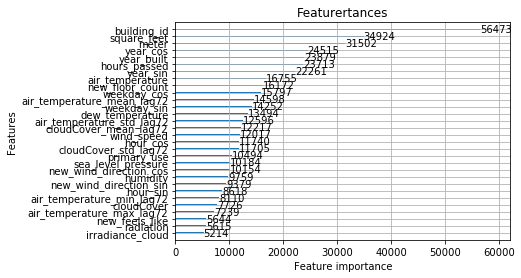

<Figure size 10800x11520 with 0 Axes>

<Figure size 10800x11520 with 0 Axes>

In [179]:
import matplotlib.pyplot as plt

lgb.plot_importance(estimator, max_num_features=30)
plt.title("Featurertances")
plt.show()
plt.figure(figsize=(150,160))

In [183]:
mean_performance_test = 0 
mean_performance_train = 0
mean_performance_leaked = 0

In [184]:
performance_test = estimator.best_score['valid_1']['rmse']
performance_train = estimator.best_score['training']['rmse']

mean_performance_test += performance_test
mean_performance_train += performance_train
gc.collect()

i = 0
step = 100000
test['pred'] = np.nan
while i < test.shape[0]:
    test.loc[i:(i+step-1),'pred'] = estimator.predict(test.iloc[i:(i+step)][features])
    i = i + step
    gc.collect()
print("Done with the test prediction")

performance_leaked = np.sqrt(mean_squared_error(test['meter_reading_log'],test['pred']))
mean_performance_leaked += performance_leaked

with open(r'./models/perf_leaked.csv', 'a') as f:
    writer = csv.writer(f)
    writer.writerow([cv_method, fold, performance_train, performance_test, performance_leaked])

    
print((mean_performance_train),(mean_performance_test),(mean_performance_leaked))

Done with the test prediction
0.3061092241759836 0.6473360580111542 2.4207903193759486


In [ ]:
i = 0
step = 100000
test['pred'] = np.nan
while i < test.shape[0]:
    test.loc[i:(i+step-1),'pred'] = estimator.predict(test.iloc[i:(i+step)][features])
    i = i + step
    gc.collect()
print("Done with the test prediction")

In [ ]:
test.dtypes

In [ ]:
train.dtypes

In [ ]:
test['meter_reading_log'].loc[0:100].plot()
test['pred'].loc[0:100].plot()

In [ ]:
start = 26600
end = 26700
test['meter_reading_log'].iloc[start:end].plot()
test['pred'].iloc[start:end].plot()

# Save results

In [ ]:
mean_performance_leaked = mean_performance_leaked/n_split
mean_performance_test = mean_performance_test/n_split
mean_performance_train = mean_performance_train/n_split

with open(r'./models/perf_leaked.csv', 'a') as f:
    writer = csv.writer(f)
    writer.writerow([cv_method, 'avg', mean_performance_train, mean_performance_test, mean_performance_leaked])

# Backup Code

In [ ]:
beaufort = [(0, 0, 0.3), (1, 0.3, 1.6), (2, 1.6, 3.4), (3, 3.4, 5.5), (4, 5.5, 8), (5, 8, 10.8), (6, 10.8, 13.9), 
          (7, 13.9, 17.2), (8, 17.2, 20.8), (9, 20.8, 24.5), (10, 24.5, 28.5), (11, 28.5, 33), (12, 33, 200)]

for item in beaufort:
    train.loc[(train['wind_speed']>=item[1]) & (train['wind_speed']<item[2]), 'beaufort_scale'] = item[0]
    train.loc[(train['new_wind_speed']>=item[1]) & (train['new_wind_speed']<item[2]), 'beaufort_scale'] = item[0]

In [ ]:
le = LabelEncoder()

for f in ['meter','primary_use','is_day_saving','is_holiday']:
    train[f] = train[f].astype('category')
    train[f] = le.fit_transform(train[f])